This will be for the sorption system. This streamlines the process of extracting usable data from the raw data.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


To use:

1.   Need to upload the raw data from sorption system to Pascal Drive
2.   Need to modify "report.csv" manually since pandas isn't smart enough. Use  
         ctrl + f to replace all "," with "". Should be 5 replacements if 1 temp test. Upload this new report to the drive
3.   Need to change file path names for "data.csv" and "report.csv"
4.   Change the mass of sample, temp of run (to one decimal since used for name
         searching later), name of sample, working gas
5.   This script can do only one test temp at a time, similar to the Excel  
     sheet has one sheet per temp.
6.   Should run in ~5s.
7.   Happy sorption!



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
gasvolreal 4.590250223433
v_sample_holder, 3.59281546300944


<ipython-input-2-2f6f06d898b4>:238: RuntimeWarning: invalid value encountered in scalar divide
  n_chargingChamber_post[i] = (run_post[i-1,1] - p_vac[i]) * v_charge[i-1] / (run_post[i-1,2] *8.314*10**6 * T_run_K)


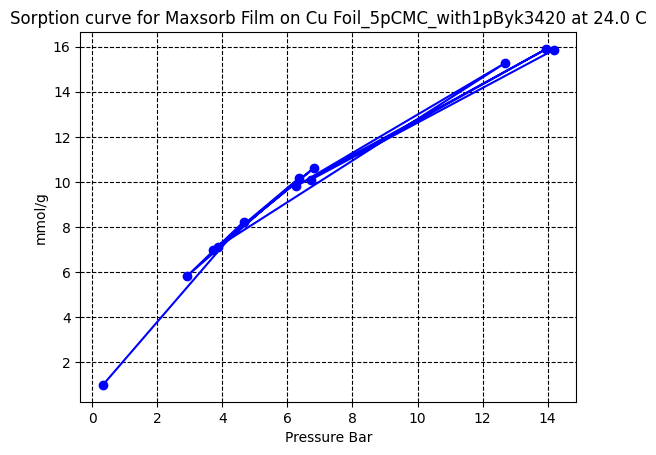

[  4.7907366   67.48177904  42.41777827  92.24337498  53.79916026
  98.68747803  56.12899751 184.07394337  90.6621497  202.42723684
  97.61566089 205.7702903 ]
[ 0.98765153  8.22609813  5.82970706 10.16902519  6.95680294 10.60258836
  7.13023906 15.2753535   9.79698934 15.90047059 10.10184128 15.85827694]
The density of the sample is 2.2 g/cm^3
The code has finished running


In [2]:
%reset
from re import M
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statistics as st





# See PyCharm help at https://www.jetbrains.com/help/pycharm/

#Things the user must input
#This script can only find curves for one temp, so need to change here for more runs (basically one sheet)
mass_sample = 0.1980 #g this is mass AC + binder, not counting the Cu foil
T_run_C = 24.0 #C
name_compound = "Maxsorb Film on Cu Foil_5pCMC_with1pByk3420"
working_gas = "CO2" #This has to match the same syntax as the report.csv
T_run_K = T_run_C + 273.15 #K

#This is to select for the correct viral coefficient for the working gas
gas=0;
if working_gas == "CO2":
    gas=1
elif working_gas == "C3H8":
    gas=0

#Loading the data
data = pd.read_csv('/content/gdrive/Shareddrives/Pascal/Technology/Chemistry/Jinyoung/archive/Sharon/Experimental Documentation/Sorption/Raw Data/250317-1641-250317_95-5_max3-cmc_1pbyk3420_oncufoil_0p1980g_flip_pressure/data.csv')

#Loading the report, need to get rid of all commas inside the csv file for this version
report = pd.read_csv('/content/gdrive/Shareddrives/Pascal/Technology/Chemistry/Jinyoung/archive/Sharon/Experimental Documentation/Sorption/Raw Data/250317-1641-250317_95-5_max3-cmc_1pbyk3420_oncufoil_0p1980g_flip_pressure/report - report (1).csv', quotechar="'", encoding='latin-1')

#Parameters that I keep between experiments

#Density sheet
#Chamber volume
v_c_small = 9.141 #cm^3, I think there is a typo in the Excel sheet
#v_c_small = 8.965631287988177 #cm^3 -> from new calibration calculation 241223
v_c_large = 9.446 #cm^3, not used in density calculation but later

#Virial Constants for N2
a_N2 = 185.4 #cm^3/mol
b_N2 = 141.8 #cm^3/mol
c_N2 = 88.7 #K

#Gas Constant
R = 1205.9 #psi*cm^3/K*mol

#Temperature
T_C_N2 = 24 #C
T_K_N2 = T_C_N2+273.15 #K

#Second Virial Coefficient
B_N2 = a_N2 - b_N2 * np.exp(c_N2/T_K_N2) #cm^3/mol


#Now calculating the density sheet
N2_initial = np.zeros(3)
N2_final = np.zeros(3)
vacuum_N2_start = np.zeros(3)
vacuum_N2_raw = np.zeros(3)
vacuum_N2_zeroed_initial = np.zeros(3)
vacuum_N2_zeroed_final = np.zeros(3)
PRT_initial = np.zeros(3)
PRT_final = np.zeros(3)
M_vol_initial = np.zeros(3)
M_vol_final = np.zeros(3)
M_vol_ratio = np.zeros(3)
gas_vol = np.zeros(3)
gas_vol_real = 0; #cm^3
v_sample_holder = 3.59281546300944 #cm^3, this comes from calibration experiments
#v_sample_holder = 3.4796267808604346 #cm^3, from new calibration 241223



#This is the key labels we need to search for
s1 = 'Sequence 1: N2 at 60.0 Â°C'
s2 = 'Sequence 2: N2 at 60.0 Â°C'
s3 = 'Sequence 3: N2 at 60.0 Â°C'

#This will look through the report labels
for i in range(len(report)):
    #These are finding the initial and final N2 pressures
    if report.iloc[i,0]==s1:
        N2_initial[0] = report.iloc[i+8,1]
        N2_final[0] = report.iloc[i+10,1]
        vacuum_N2_start[0] = (report.iloc[i+3,1])
    elif report.iloc[i,0]==s2:
        N2_initial[1] = report.iloc[i+8,1]
        N2_final[1] = report.iloc[i+10,1]
        vacuum_N2_start[1] = (report.iloc[i + 3, 1])
    elif report.iloc[i,0]==s3:
        N2_initial[2] = report.iloc[i+8,1]
        N2_final[2] = report.iloc[i+10,1]
        vacuum_N2_start[2] = (report.iloc[i + 3, 1])

vacuum_N2_start = np.floor(vacuum_N2_start)

#Here is finding the raw vacuum data
for i in range(len(vacuum_N2_raw)):
    #This is the orange vacuum pressures for zeroing
    vacuum_N2_start[i] = int(vacuum_N2_start[i])
    vacuum_N2_raw[i] = np.mean(data.iloc[(int(vacuum_N2_start[i])-100):int(vacuum_N2_start[i]),2])

    #This is doing the zeroing
    vacuum_N2_zeroed_initial[i] = N2_initial[i] - vacuum_N2_raw[i]
    vacuum_N2_zeroed_final[i] = N2_final[i] - vacuum_N2_raw[i]

    #This is doing some P/RT calculations
    PRT_initial[i] = vacuum_N2_zeroed_initial[i]/(R*T_K_N2)
    PRT_final[i] = vacuum_N2_zeroed_final[i] / (R * T_K_N2)

    #This is doing molar volume calculations
    M_vol_initial[i] = (1 + np.sqrt(1 - 4 * PRT_initial[i] * (-B_N2))) / (2 * PRT_initial[i])
    M_vol_final[i] = (1 + np.sqrt(1 - 4 * PRT_final[i] * (-B_N2))) / (2 * PRT_final[i])
    M_vol_ratio[i] = M_vol_final[i] / M_vol_initial[i] - 1

    #This is calculating sample volume
    gas_vol[i] = v_c_small * M_vol_ratio[i]
#THIS MIGHT BE AN ERROR, SEEMS TO BE OFF BY 0.001 CM^3


gas_vol_real = np.mean(gas_vol)
v_sample = v_sample_holder - gas_vol_real #cm^3
################################################
#For Maxsorb, this thesis measured skeletal density to be 2.1 g/cc via helium pycnometetry: https://thesis.library.caltech.edu/9907/19/Murialdo_Maxwell_Thesis_Ch4.pdf
#This matches a sample volume of 0.11, however if you modify that to be any value between 0.1 and 0.8, the mol gas doesn't really change, though the density will.
#############################################3
v_sample = mass_sample / 2.2 #hardcoded in, maxsorb has a skeletal density of ~2.2 g/cc (https://www.energy.gov/eere/fuelcells/articles/sorption-storage-technology-summary), our n2 pycnometry experiment won't give us an accurate surface area, so this is more believable
density_sample = mass_sample / v_sample #g/cm^3

print('gasvolreal', gas_vol_real)
print('v_sample_holder,', v_sample_holder)


#Now calculating the sorption and desorption curve at a specific temp
[r,c]=report.shape

#This is for finding background vacuum pressure
#This is the key labels we need to search for
s5 = 'Sequence 5: ' + working_gas + ' at ' + str(T_run_C) +' Â°C'

#These are parameters
run_start = 0 #This is when the CO2 or C3H8 gets injected
run_raw_background_high_P = np.zeros(300)
run_raw_background_low_P = np.zeros(300)

#These are the things the person will copy over
run_initial = np.zeros((c+1)*3).reshape(c+1,3)
run_final = np.zeros((c+1)*3).reshape(c+1,3)
run_post = np.zeros((c+1)*3).reshape(c+1,3)
v_charge = np.zeros(c+1)
p_vac = np.zeros(c+1)
n_tot = np.zeros(c+1)

#This will look through the report labels
for i in range(len(report)):
    #These are finding the raw background vacuum pressures
    if report.iloc[i,0]==s5:
        run_start = np.floor(float((report.iloc[i+3,1])))
        run_raw_background_high_P = data.iloc[(int(run_start) - 300):int(run_start), 1]
        run_raw_background_low_P = data.iloc[(int(run_start) - 300):int(run_start), 2]

# THIS IS PULLING THE DATA WEIRDLY, COULD BE AN ERROR
        run_initial[1:-1,0] = report.iloc[i + 8, 1:c]
        run_final[1:-1,0] = report.iloc[i + 9, 1:c]
        run_post[1:-1,0] = report.iloc[i + 10, 1:c+1]
        v_charge[1:-1] = report.iloc[i + 13, 1:c]


#This finds the backgound pressure in vacuum before the run
run_vacuum_background_low = np.mean(run_raw_background_low_P)
run_vacuum_background_high = np.mean(run_raw_background_high_P)



#Need to set the first part of run_post
#run_post[0,0] = run_vacuum_background_low
#run_post[1,0] = run_vacuum_background_low * 6894.76
#run_post[2,0] = 1

#Parameters for temperature sheets
v_v = 0.02252 #cm^3 VALVE VOLUME

B_star=np.zeros(2)
#This is B_Star (second virial coefficient (swapped to m^3/mol) / RT) for propane. Source is "Virial coefficients of pure gasses landolt bornstein numerical data... ISBN 3-540-43345-7 Springer-Verlag Berlin Heidelberg New York"
B_star[0] = (1.0971 * 10**2 - 8.4673 * 10**4 / T_run_K - 8.1215 * 10**6 / (T_run_K**2) - 3.482 * 10**9 / (T_run_K**3)) / (8.314 * 10**6 * T_run_K)
#This is B_Star for CO2
B_star[1] = (5.74*10 - 3.8829 * 10**4 / T_run_K + 4.2899 * 10**5 / (T_run_K**2) - 1.4661 * 10**9 / (T_run_K**3)) / (8.314 * 10**6 * T_run_K)

#This is finding the right charge volume and pressure vac
for i in range(len(v_charge)):
    if v_charge[i] == v_c_small:
        p_vac[i] = run_vacuum_background_low * 6894.76 #converting to Pa from PSI
    elif v_charge[i] == v_c_large:
        p_vac[i] = run_vacuum_background_high * 6894.76


#This adds the P_post initial conditions
run_post[0] = run_vacuum_background_low

#Now we have to calculate the other terms in the pressure stuff
for i in range(len(run_initial)):
    run_initial[i,1] = run_initial[i,0] * 6894.76
    run_initial[i,2] = 1 + B_star[gas] * (run_initial[i,1]-p_vac[i])
    #This is the compressibility factor for correcting the non-ideality of the gas.
    #For an ideal gas, Z = 1 (Bstar = 0), or Z = PV/RT. In real systems, PV/RT = Z = 1 + B*P + C*P^2... etc.
    #Here, we correct the pressure with the vacuum background, then multiply by the virial coefficient correction

for i in range(len(run_final)):
    run_final[i,1] = run_final[i,0] * 6894.76
    run_final[i,2] = 1 + B_star[gas] * (run_final[i,1]-p_vac[i])

for i in range(len(run_post)-1):
    run_post[i,1] = run_post[i,0] * 6894.76
    if i == 0:
        run_post[i,2] = 1
    else:
        run_post[i,2] = 1 + B_star[gas] * (run_post[i,1]-p_vac[i+1])
    #Due to some insanity with the spreadsheet, the "post" data is offset by one

#Now find n_tot
#This calculates the total moles absorbed - note it is off from the Excel sheet since v_c was wrong in the sheet I think

n_chargingChamber = np.zeros(c)
for i in range(len(n_tot)-1):
    n_chargingChamber[i] = (run_initial[i,1]-p_vac[i]) * v_charge[i] / (run_initial[i,2] * 8.314 * 10**6 * T_run_K)

n_bothChambers = np.zeros(c)
for i in range(len(n_tot)-1):
    n_bothChambers[i] = (run_final[i-1,1] - p_vac[i]) * (v_charge[i-1] + v_sample_holder + v_v - v_sample) / (run_final[i-1,2] * 8.314 * 10**6 * T_run_K)

n_chargingChamber_post = np.zeros(c)
for i in range(len(n_tot)-1):
    n_chargingChamber_post[i] = (run_post[i-1,1] - p_vac[i]) * v_charge[i-1] / (run_post[i-1,2] *8.314*10**6 * T_run_K)

n_bothChambers_post = np.zeros(c)
for i in range(len(n_tot)-1):
    n_bothChambers_post[i] = (run_final[i,1] - p_vac[i]) * (v_charge[i] + v_sample_holder + v_v - v_sample) / (run_final[i,2] * 8.314*10**6 * T_run_K)


    #The N_Tot calculation is a mass balance.
    #The equation is: ns_Tot(i) = ns_Tot(i-1) + n_chargingChamber + n_BothChambers(i-1) - n_ChargingChamber(PostPressure)(i-1) - n_BothChambers(i)
    #ns_Tot(i-1) is the number of mol already sorbed in the sample
    #n_chargingChamber is the corrected charging pressure * volume of charging chamber / ZRT
    #n_BothChambers(i-1) is corrected equilibrium pressure from last datapoint * (Vcharging chamber + VSampleChamber + ValveVolume - Sample volume) / ZRT
    #n_charging chmaber (post pressure) is postpressure from last datapoint times Vcharging chamber
    #n_bothchambers(i) is this datapoint's equilibrium pressure times all the volumes

    # To walk through the experiment:
    #There's a charging chamber, and a sample chamber. The charging chamber is brought to a target pressure, the valve opened, and the two chambers equilibrated
    #Gas is stored in the sample (sorbed), and in the atmosphere in the two chambers.
    #The spreadsheet is completely insane and difficult to read, but it is looking at all these small other volumes to make sure we're accounting for everything.
    #To me, I still cannot follow where everything is - various terms are offset in odd ways, so "i" doesn't line up with each datapoint correctly.

    #If I am following, one "delta" is from n_charging chamber and n_charging chamber post pressure. This says "this difference is the number of moles of gas we are introducing into the system when we change the charge pressure"
    #The other "delta" is the change in the two equilibrium pressures for the whole chamber. Pressure in the whole chamber means moles of gas that are NOT sorbed in the sample
    #So you could think of it as N_sample[i] + N_chamber[i] = N_sample[i-1] + N_chamber[i-1] + DeltaN_Added -> Then, just pop everything in terms of PV/ZRTs, and we're in businesss

for i in range(len(n_tot)-1):
    if i == 0:
        n_tot[i] = 0
    else:
        n_tot[i+1] = n_tot[i] + n_chargingChamber[i] + n_bothChambers[i] - n_chargingChamber_post[i] - n_bothChambers_post[i]

#Calculate the rest of the sheet columns
p_bar = np.zeros(c-1)
for i in range(len(p_bar)):
    p_bar[i] = run_final[i+1,1] / 100000



C_STP = n_tot * 22.4 *1000 / v_sample #cm^3 (STP) /cm^3
C_mmol = np.zeros(c-1)


for i in range(len(C_mmol)):
    C_mmol[i] = n_tot[i+2] * 1000 / mass_sample

p_bar24 = p_bar
C_mmol24 = C_mmol


#Now plotting the data
plt.plot(p_bar, C_mmol,'bo-')
plt.xlabel("Pressure Bar")
plt.ylabel("mmol/g")
plt.title("Sorption curve for " + str(name_compound) + " at " + str(T_run_C) + " C")
plt.grid(visible=True, which='major', color='k', linestyle='--')
plt.grid(visible=True, which='minor', color='k', linestyle='--')
plt.show()

print(p_bar*14.504)
print(C_mmol)

print("The density of the sample is " + str(density_sample) + " g/cm^3")
print("The code has finished running")


Now we try to find the kinetics of sorption and desorption based on the raw data

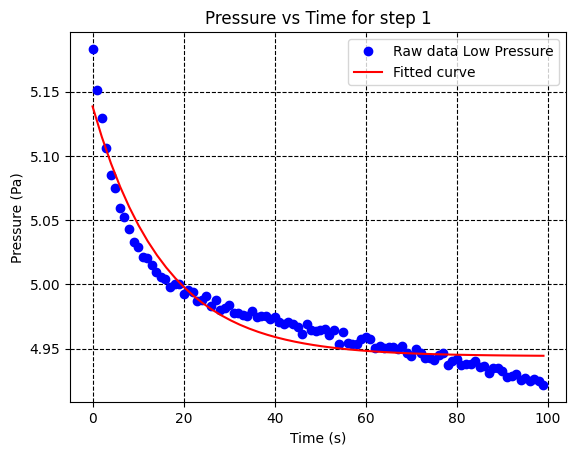

The decay constant b is 0.0640362691124411/sec
The scale constant a is 0.1944864910192266Pa
The shift constant c is 4.944070100525522Pa


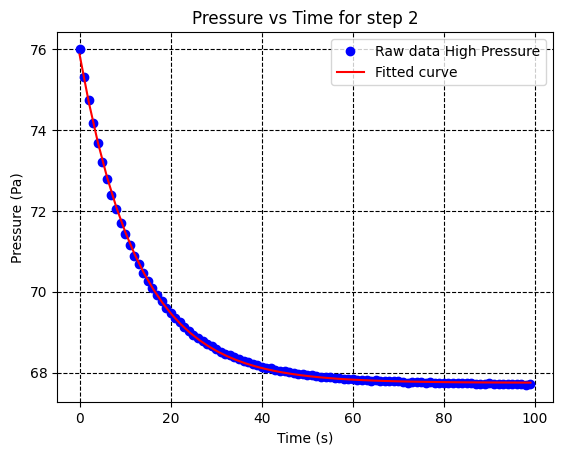

The decay constant b is 0.07758412585681856/sec
The scale constant a is 8.122901979554456Pa
The shift constant c is 67.74797394927651Pa


<ipython-input-48-293a599851cf>:72: RuntimeWarning: overflow encountered in exp
  popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, x, y)


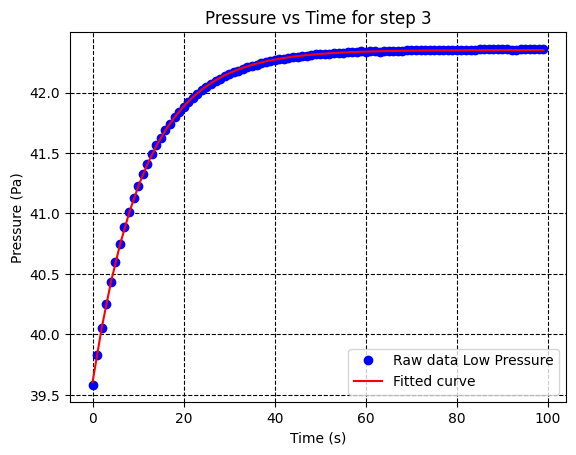

The decay constant b is 0.08871403993411611/sec
The scale constant a is -2.744669944317023Pa
The shift constant c is 42.35141956249281Pa


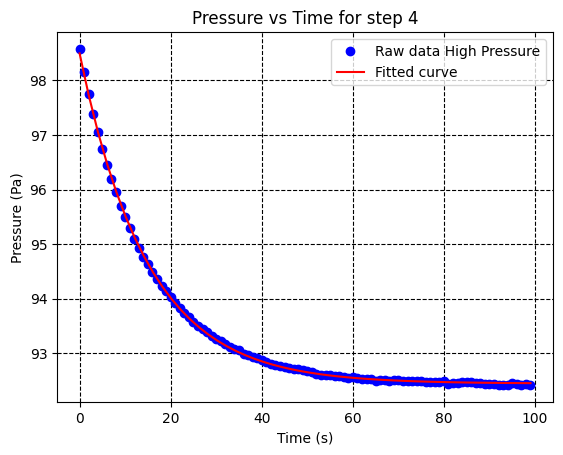

The decay constant b is 0.06743439068883486/sec
The scale constant a is 6.048236358692159Pa
The shift constant c is 92.44551337766117Pa


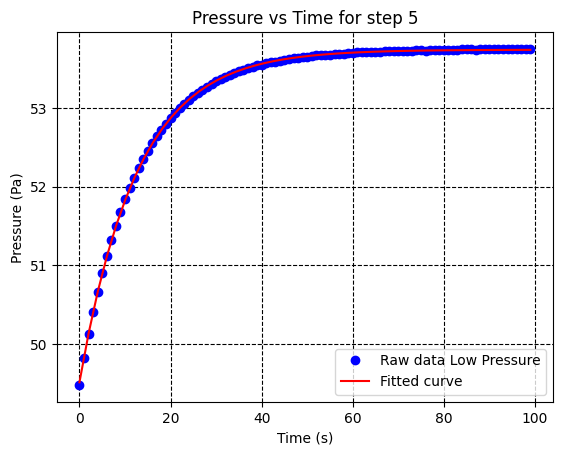

The decay constant b is 0.07907833635012301/sec
The scale constant a is -4.223413106231265Pa
The shift constant c is 53.73912618963476Pa


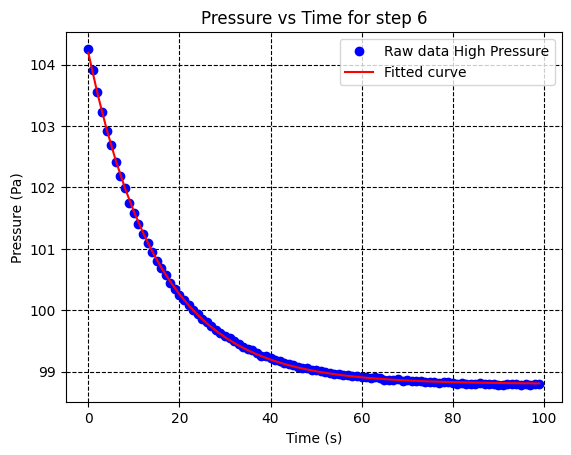

The decay constant b is 0.06528396681517051/sec
The scale constant a is 5.394828946944134Pa
The shift constant c is 98.79843187826914Pa


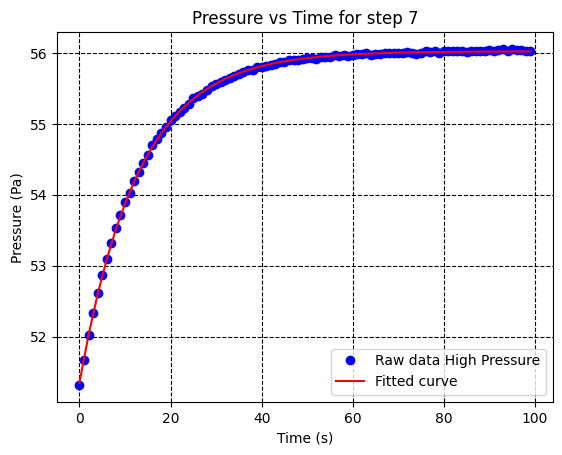

The decay constant b is 0.07762859012136379/sec
The scale constant a is -4.674337196304684Pa
The shift constant c is 56.02339973580894Pa


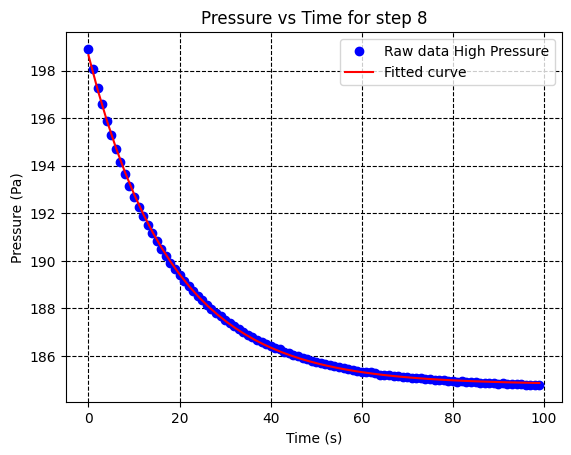

The decay constant b is 0.054739064423199056/sec
The scale constant a is 13.843082571583807Pa
The shift constant c is 184.80506787977683Pa


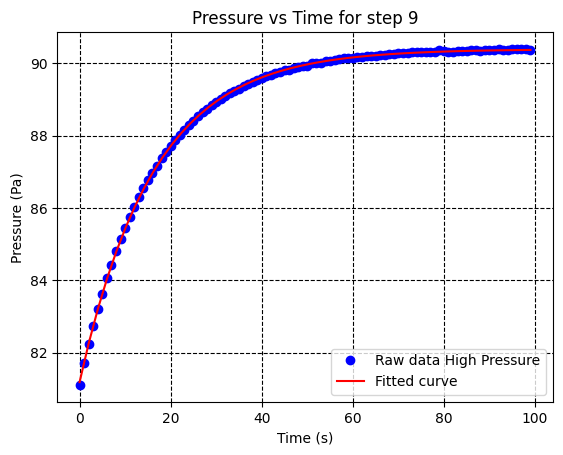

The decay constant b is 0.06171354804432135/sec
The scale constant a is -9.200484389567569Pa
The shift constant c is 90.38978775412272Pa


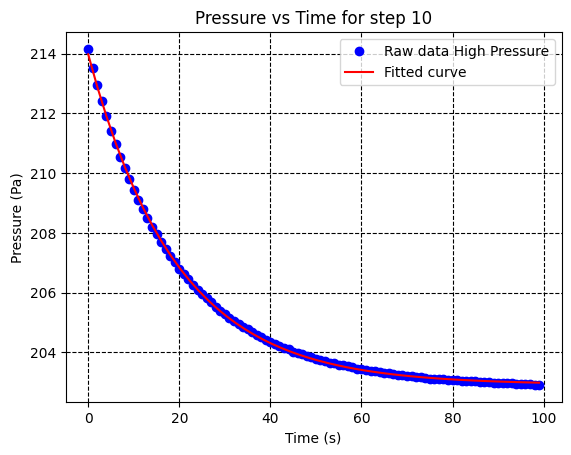

The decay constant b is 0.05184500658076406/sec
The scale constant a is 11.06930372621605Pa
The shift constant c is 202.91235998015722Pa


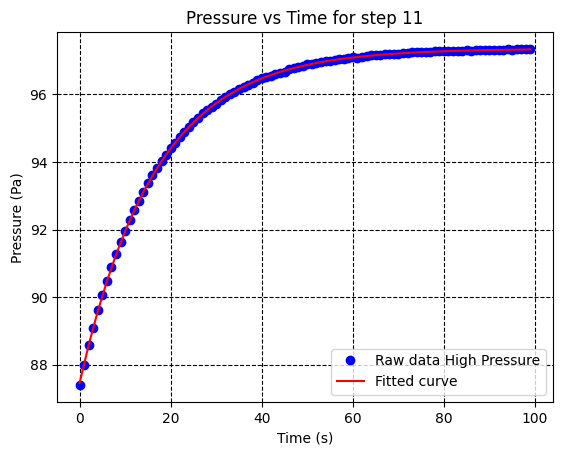

The decay constant b is 0.060509100982533565/sec
The scale constant a is -9.901930581090452Pa
The shift constant c is 97.35677557684102Pa
The run starts at [23075. 26233. 29469. 32626. 35862. 39020. 42256. 45529. 48783. 52057.
 55311.     0.]
The run ends at [25841. 28999. 32236. 35392. 38628. 41786. 45023. 48296. 51549. 54824.
 58077.     0.]
The set pressures are [ 14. 140.  14. 140.  14. 140.  14. 280.  14. 280.  14. 280.]
The low pressure kinetic constants are [0.         0.06403627 0.08871404 0.07907834] with mean 0.05795716134917006/sec
The high pressure kinetic constants are [0.         0.07758413 0.06743439 0.06528397 0.07762859 0.05473906
 0.06171355 0.05184501 0.0605091 ] with mean 0.05741531039033397/sec


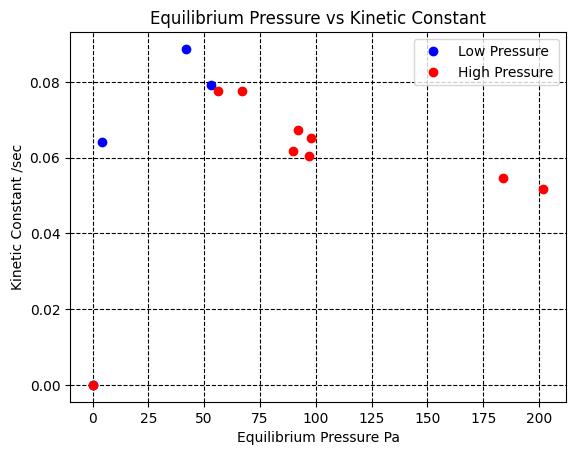

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statistics as st #This imports the module or you can use numpy

def pressure_decay(t, P0, Peq, tau):
    return Peq + (P0 - Peq) * np.exp(t / tau)

#These are parameters
num_steps = 12 #This is how many steps the user inputed into the sorption run
T_run_C = 24.0 #C
T_run = T_run_C + 273.15 #K
#This is the key labels we need to search for
s_look = 'Sequence 5: ' + working_gas + ' at ' + str(T_run_C) +' Â°C'

#These are the variables
run_start = np.zeros(num_steps) #This is when the step starts
run_end = np.zeros(num_steps) #This is when the step finishes
run_gap = np.zeros(num_steps) #This is how many data points per step
set_pressure = np.zeros(num_steps) #This is the setpoints
expo_start = np.zeros(num_steps) #This is the real start of the exponential curve
final_pressure = np.zeros(num_steps) #This is the end pressure of the step

#Store the data
high_P_kinetics = [0]
low_P_kinetics = [0]
high_P_eq = [0]
low_P_eq = [0]

#This is what pressure the pressure gauge flips from small to large
P_threshold = 55 #Psi

#This will look through the report labels
for i in range(len(report)):
    #These are finding the raw background vacuum pressures
    if report.iloc[i,0]==s_look:
        for j in range(num_steps-1):
            run_start[j] = np.floor(float((report.iloc[i+3,j+1])))  #This pulls from the start line
            run_end[j] = np.floor(float((report.iloc[i+3,j+2])))    #This pulls from the start line
            run_gap[j] = run_end[j] - run_start[j]
            expo_start[j] = run_start[j] = np.floor(float((report.iloc[i+4,j+1])))  #This pulls from the hold line in the report
            final_pressure[j] = np.floor(float((report.iloc[i+9,j+1])))
        for j in range(num_steps):
            set_pressure[j] = report.iloc[i+7,j+1]

#Need to set the data holding correctly for each run
for i in range(num_steps-1):
    #run_raw_high_P = np.zeros(int(run_gap[i]))
    #run_raw_low_P = np.zeros(int(run_gap[i]))

    #We add t_delay data points to avoid the initial extreme change in pressure associated with opening the valve
    t_delay = 10

    #We only fit t_fit data points otherwise it will overfit the tail
    t_fit = 100 + t_delay

    run_raw_high_P = data.iloc[(int(expo_start[i]) + t_delay):(int(expo_start[i]) + t_fit), 1]
    run_raw_low_P = data.iloc[(int(expo_start[i]) + t_delay):(int(expo_start[i]) + t_fit), 2]
    time_steps = [i for i in range(int(expo_start[i] + t_delay), int(expo_start[i]) + t_fit)]
    time_steps_zeroed = [i for i in range(0, t_fit-t_delay)]

    #print("This is the data for high pressure " + str(run_raw_high_P))
    #print("This is the data for low pressure " + str(run_raw_low_P))

    plt.figure()
    if final_pressure[i] < P_threshold:
      #This is the low pressure gauge

        x = time_steps_zeroed
        y = run_raw_low_P

        popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, x, y)

        a = popt[0]
        b = popt[1]
        c = popt[2]

        x_fitted = np.linspace(np.min(x), np.max(x))
        y_fitted = a * np.exp(-b * x_fitted) + c

        # Plot
        plt.plot(x, y,'bo', label='Raw data Low Pressure')
        plt.plot(x_fitted, y_fitted, 'r', label='Fitted curve')

        low_P_kinetics.append(b)
        low_P_eq.append(final_pressure[i])

    else:
      #This is the high pressure gauge

        x = time_steps_zeroed
        y = run_raw_high_P

        #Had to put in a better guess otherwise the code was fitting incorrectly
        popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, x, y, p0 = [-4,0.1,100], maxfev = 10000)

        a = popt[0]
        b = popt[1]
        c = popt[2]

        x_fitted = np.linspace(np.min(x), np.max(x))
        y_fitted = a * np.exp(-b * x_fitted) + c

        # Plot
        plt.plot(x, y,'bo', label='Raw data High Pressure')
        plt.plot(x_fitted, y_fitted, 'r', label='Fitted curve')

        high_P_kinetics.append(b)
        high_P_eq.append(final_pressure[i])



    plt.title("Pressure vs Time for step " + str(i+1))
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (Pa)")
    plt.legend()
    plt.grid(visible=True, which='major', color='k', linestyle='--')
    plt.grid(visible=True, which='minor', color='k', linestyle='--')
    plt.show()

    print("The decay constant b is " + str(b) + "/sec")
    print("The scale constant a is " + str(a) + "Pa")
    print("The shift constant c is " + str(c) + "Pa")



#Convert to array
high_P_kinetics = np.array(high_P_kinetics)
low_P_kinetics = np.array(low_P_kinetics)
high_P_eq = np.array(high_P_eq)
low_P_eq = np.array(low_P_eq)

print("The run starts at " + str(run_start))
print("The run ends at " + str(run_end))
print("The set pressures are " + str(set_pressure))
print("The low pressure kinetic constants are " + str(low_P_kinetics) + " with mean " + str(np.mean(low_P_kinetics)) + "/sec")
print("The high pressure kinetic constants are " + str(high_P_kinetics) + " with mean " + str(np.mean(high_P_kinetics)) + "/sec")


plt.figure()
plt.plot(low_P_eq,low_P_kinetics,'bo', label='Low Pressure')
plt.plot(high_P_eq,high_P_kinetics,'ro', label='High Pressure')
plt.title("Equilibrium Pressure vs Kinetic Constant")
plt.xlabel("Equilibrium Pressure Pa")
plt.ylabel("Kinetic Constant /sec")
plt.legend()
plt.grid(visible=True, which='major', color='k', linestyle='--')
plt.grid(visible=True, which='minor', color='k', linestyle='--')
plt.show()
